In [1]:
import functools

import jax
import jax.experimental.pallas as pl
from jax.experimental.pallas import tpu as pltpu
import jax.numpy as jnp
from jax import random
import numpy as np

In [2]:
def matmul_kernel(x_ref, y_ref, z_ref, acc_ref, *, nsteps):
  """Steps of a matrix contraction comprising `nsteps` block matmuls."""

  # Initialize `acc_ref` on VMEM.
  @pl.when(pl.program_id(2) == 0)
  def _(): acc_ref[...] = jnp.zeros_like(acc_ref)

  # Load the inputs into VREG, perform matmul, then store the results in VMEM.
  acc_ref[...] += jnp.dot(
      x_ref[...], y_ref[...], preferred_element_type=jnp.float32
  )

  # Cast `acc_ref` to the output dtype and write to VMEM.
  @pl.when(pl.program_id(2) == nsteps - 1)
  def _(): z_ref[...] = acc_ref[...].astype(z_ref.dtype)


@functools.partial(jax.jit, static_argnames=['bm', 'bk', 'bn'])
def matmul(
    x: jax.Array,
    y: jax.Array,
    *,
    bm: int = 128,
    bk: int = 128,
    bn: int = 128,
):
  m, k = x.shape
  _, n = y.shape
  return pl.pallas_call(
      functools.partial(matmul_kernel, nsteps=k // bk),
      grid_spec=pltpu.PrefetchScalarGridSpec(
        num_scalar_prefetch=0,
        in_specs=[
            pl.BlockSpec((bm, bk), lambda i, j, k: (i, k)),
            pl.BlockSpec((bk, bn), lambda i, j, k: (k, j)),
        ],
        out_specs=pl.BlockSpec((bm, bn), lambda i, j, k: (i, j)),
        scratch_shapes=[pltpu.VMEM((bm, bn), jnp.float32)],  # type: ignore
        grid=(m // bm, n // bn, k // bk),
      ),
      out_shape=jax.ShapeDtypeStruct((m, n), x.dtype),
      compiler_params=pltpu.TPUCompilerParams(
          dimension_semantics=("parallel", "parallel", "parallel")),
  )(x, y)

In [3]:
m, k, n = 4096, 4096, 4096
k1, k2 = random.split(random.key(0), 2)
x = random.normal(k1, (m, k), dtype=jnp.bfloat16)
y = random.normal(k2, (k, n), dtype=jnp.bfloat16)
np.testing.assert_array_equal(x @ y, matmul(x, y))

Check the jaxpr of the matmul kernel

In [4]:
jax.make_jaxpr(matmul)(jax.ShapeDtypeStruct((4096, 4096), jnp.bfloat16), jax.ShapeDtypeStruct((4096, 4096), jnp.bfloat16))

{ lambda ; a:bf16[4096,4096] b:bf16[4096,4096]. let
    c:bf16[4096,4096] = pjit[
      name=matmul
      jaxpr={ lambda ; a:bf16[4096,4096] b:bf16[4096,4096]. let
          c:bf16[4096,4096] = pallas_call[
            backend=None
            compiler_params={'mosaic_tpu': TPUCompilerParams(dimension_semantics=('parallel', 'parallel', 'parallel'), allow_input_fusion=None, vmem_limit_bytes=None, collective_id=None, has_side_effects=False, flags=None, internal_scratch_in_bytes=None, serialization_format=1, kernel_type=<KernelType.TC: 0>, disable_bounds_checks=False)}
            cost_estimate=None
            debug=False
            grid_mapping=GridMapping(grid=(32, 32, 32), grid_names=None, block_mappings=(BlockMapping(block_shape=(Blocked(block_size=128), Blocked(block_size=128)), transformed_block_aval=MemRef<None>{bfloat16[128,128]}, index_map_jaxpr={ lambda ; a:i32[] b:i32[] c:i32[]. let  in (a, c) }, array_shape_dtype=ShapeDtypeStruct(shape=(4096, 4096), dtype=bfloat16), origin='

In [24]:
import timeit

v5e_flops = 197e12
v5e_membw = 819e9
v5e_op_intensity = v5e_flops / v5e_membw  # ~240.5

def matmul_flops(m: int, k: int, n: int):
  return 2 * m * k * n

def matmul_membw(m: int, k: int, n: int, dtype: jnp.dtype):
  return (m * k + k * n + m * n) * np.dtype(dtype).itemsize

def benchmark(f, min_time: float = 30.0):
  def run(*args, **kwargs):
    # Compile function first
    jax.block_until_ready(f(*args, **kwargs))
    # Time function until we exceed min_time
    trials = 0
    total_time = 0.0
    start = timeit.default_timer()
    
    while total_time < min_time:
      jax.block_until_ready(f(*args, **kwargs))
      trials += 1
      total_time = timeit.default_timer() - start
      
    time_per_iter = total_time / trials
    return time_per_iter
  return run

def analyze_matmul(m: int, k: int, n: int, dtype: np.dtype,
                   mm_func):
  x = jnp.ones((m, k), dtype=dtype)
  y = jnp.ones((k, n), dtype=dtype)
  time = benchmark(mm_func)(x, y)
  print(f"----- {m} x {k} x {n} -----")
  print("Matmul time: ", time)
  mm_flops = matmul_flops(m, k, n) / time
  print("Matmul FLOP/s: ", mm_flops)
  print(f"FLOP/s utilization: {mm_flops / v5e_flops * 100:.4f}%")
  print()
  return mm_flops

print("================bm=128, bk=128, bn=128===================")
mm = functools.partial(matmul, bm=128, bk=128, bn=128)
analyze_matmul(1024, 1024, 1024, jnp.bfloat16, mm)
analyze_matmul(4096, 4096, 4096, jnp.bfloat16, mm)
analyze_matmul(8192, 8192, 8192, jnp.bfloat16, mm)

print("================bm=512, bk=512, bn=512===================")
mm = functools.partial(matmul, bm=512, bk=512, bn=512)
analyze_matmul(1024, 1024, 1024, jnp.bfloat16, mm)
analyze_matmul(4096, 4096, 4096, jnp.bfloat16, mm)
analyze_matmul(8192, 8192, 8192, jnp.bfloat16, mm)

print("================bm=512, bk=1024, bn=1024===================")
mm = functools.partial(matmul, bm=512, bk=1024, bn=1024)
analyze_matmul(1024, 1024, 1024, jnp.bfloat16, mm)
analyze_matmul(4096, 4096, 4096, jnp.bfloat16, mm)
analyze_matmul(8192, 8192, 8192, jnp.bfloat16, mm)

================bm=128, bk=128, bn=128===================
----- 1024 x 1024 x 1024 -----
Matmul time:  0.0003136656454037781
Matmul FLOP/s:  6846410116847.733
FLOP/s utilization: 3.4753%

----- 4096 x 4096 x 4096 -----
Matmul time:  0.011466295463536582
Matmul FLOP/s:  11986343270942.48
FLOP/s utilization: 6.0844%

----- 8192 x 8192 x 8192 -----
Matmul time:  0.09125403865342421
Matmul FLOP/s:  12048909220904.295
FLOP/s utilization: 6.1162%

================bm=512, bk=512, bn=512===================
----- 1024 x 1024 x 1024 -----
Matmul time:  0.00015092577715474846
Matmul FLOP/s:  14228740036886.639
FLOP/s utilization: 7.2227%

----- 4096 x 4096 x 4096 -----
Matmul time:  0.0010908717592032634
Matmul FLOP/s:  125990018819793.14
FLOP/s utilization: 63.9543%

----- 8192 x 8192 x 8192 -----
Matmul time:  0.007453734529441836
Matmul FLOP/s:  147511508953396.5
FLOP/s utilization: 74.8789%

================bm=512, bk=1024, bn=1024===================
----- 1024 x 1024 x 1024 -----
Matmul time

180827422095375.94

Visualize the performance

In [32]:
block_sizes = [128, 256, 512]
mm_tflops = [analyze_matmul(32768, 65536, 32768, jnp.bfloat16, functools.partial(matmul, bm=s, bk=s, bn=s)) / 1e12 for s in block_sizes]

----- 32768 x 65536 x 32768 -----
Matmul time:  11.53426993972001
Matmul FLOP/s:  12201681518712.951
FLOP/s utilization: 6.1937%

----- 32768 x 65536 x 32768 -----
Matmul time:  2.367964568852375
Matmul FLOP/s:  59433950240030.78
FLOP/s utilization: 30.1695%

----- 32768 x 65536 x 32768 -----
Matmul time:  0.944758583274961
Matmul FLOP/s:  148966615225096.06
FLOP/s utilization: 75.6176%



In [33]:
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

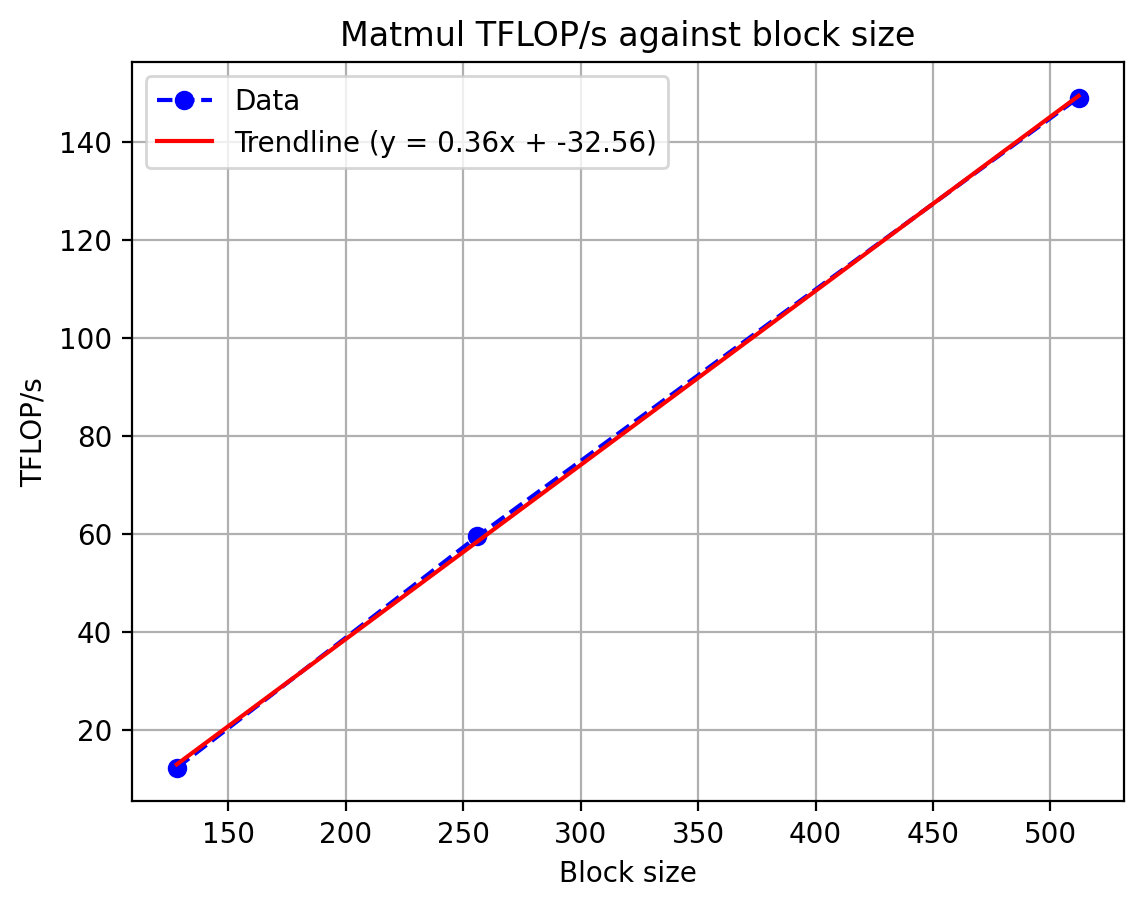

In [34]:
import numpy as np

# Calculate trendline
coeffs = np.polyfit(block_sizes, mm_tflops, 1)
fitted = np.poly1d(coeffs)

plt.plot(block_sizes, mm_tflops, 'bo--', label='Data')
plt.plot(block_sizes, fitted(block_sizes), 'r-', label=f'Trendline (y = {coeffs[0]:.2f}x + {coeffs[1]:.2f})')
plt.title('Matmul TFLOP/s against block size')
plt.ylabel('TFLOP/s')
plt.xlabel('Block size')
plt.legend()
plt.grid(True)
plt.show()

## Why does the matmul FLOP/s increase linearly with respect to block size?

This is indicative of a memory bandwidth-bound regime. In a roofline model, the
following applies when bandwidth-bound:

```
FLOP/s = bandwidth * arithmetic_intensity
```

Let's compute the arithmetic intensity and bandwidth.

In [35]:
# Assumption: HBM bandwidth is the limiting factor.
# Pallas only supports double-buffered pipelines on the TPU.
# Therefore, we further assume that one memory operation overlaps with one compute operation.
# The duration of each pipeline iteration will be bounded by the memory transfer time.

def block_size_to_arithmetic_intensity(block_size):
  # 2 bytes per element (bf16), 2 inputs, 1 output
  bytes_transferred = block_size * block_size * (2 + 1) * 2
  flops = 2 * block_size * block_size * block_size + (block_size * block_size)
  return flops / bytes_transferred

arithmetic_intensities = [block_size_to_arithmetic_intensity(s) for s in block_sizes]
print(arithmetic_intensities)

[42.833333333333336, 85.5, 170.83333333333334]


![memory_bound](https://docs.jax.dev/en/latest/_images/pipelining_bandwidth_bound.svg)

In [46]:
weights = np.ones_like([0] + arithmetic_intensities)
weights[0] = 1e5
coeffs = np.polyfit([0] + arithmetic_intensities, [0] + mm_tflops, 1, w=weights)
tflops_per_ai = coeffs[0]
print(f"Estimated memory bandwidth: {tflops_per_ai} TB/s. Hardware memory bandwidth: {v5e_membw / 1e12} TB/s")

Estimated memory bandwidth: 0.8101627325706321 TB/s. Hardware memory bandwidth: 0.819 TB/s
